In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [61]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold
import sklearn.metrics as metrics
from scipy.stats import pearsonr

# **Data Loading**

### **1- Unzipping**

In [ ]:
"""
zip_file_path1 = "/content/drive/My Drive/Problem Solving.zip"
zip_file_path2 = "/content/drive/My Drive/Problem Solving S07_S11.zip"
zip_file_path3 = "/content/drive/My Drive/New data.zip"
zip_file_path4 = "/content/drive/My Drive/14_H and MRT score.zip"
# Path to the folder to extract the zip file
extract_folder_path = "/content/drive/My Drive/Mechatronic/"

# Unzip the zip file
with zipfile.ZipFile(zip_file_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)
with zipfile.ZipFile(zip_file_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)
with zipfile.ZipFile(zip_file_path3, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)
with zipfile.ZipFile(zip_file_path4, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)
"""

### **2- Features/Target**
Note that recordings for 4th, 12th, 16th, 17th, 22nd, 31st participants are not available.

In [ ]:
available_subs = [i for i in range(1, 33) if i != 4 and i != 12 and i != 16 and i != 17 and i != 22 and i != 31]

#### **2-1- Target**
MRT scores make up the target array denoted by `y`.

In [ ]:
labels_path = "/content/drive/My Drive/Mechatronic/MRT score.xlsx"
df = pd.read_excel(labels_path)
available_subs_idx = [i-1 for i in available_subs]
y = df["MRT score/48"].values # Target values
y_df = pd.DataFrame(y, columns=["MRT Score"])
y_df # MRT score for first 5 available subjects

,MRT Score
0,45
1,32
2,47
3,44
4,23
5,40
6,46
7,34
8,44
9,41


#### **2-2- Features**

##### **2-2-1- Use of time:** The initial time of looking at the question before making any move. (denoted by `used_times`)


For each subject, use of time during each task is calculated using hand datasets, since visibility parameter determines if subjects have begun or done the task. (Only right hand is considered, since there is no such difference between right and left. When the participant is attempting the task, both hands are visible, and vice versa.)

In [ ]:
used_times = []

for i in available_subs: # Looping through all the subjects
    time = [] # A list in which 6 use of time values for each subject is added. Finally, this list is appended to "init_times[]`.
    for j in range(1, 7): # Looping through 6 tasks for each subjects
        if i < 10:
            right_hand_paths = f"/content/drive/My Drive/Mechatronic/S0{i}_H/Task{j}_right_concatenated_matrix.xlsx"
        else:
            right_hand_paths = f"/content/drive/My Drive/Mechatronic/S{i}_H/Task{j}_right_concatenated_matrix.xlsx"
        df = pd.read_excel(right_hand_paths)
        start_time_index = df[df["right_hand_V"] == 1].index[0] # When the hand is visible for the first time
        time.append(round(df["Time"][start_time_index], 2)) # For simplification, it is rounded to 2 decimal place.
    used_times.append(time)

In [ ]:
columns = ["Use of time (Task1)", "Use of time (Task2)", "Use of time (Task3)", "Use of time (Task4)", "Use of time (Task5)", "Use of time (Task6)"]
used_times_df = pd.DataFrame(used_times, columns=columns)

In [ ]:
used_times_df.head(n=5) # Use of time for first 5 available subjects

,Use of time (Task1),Use of time (Task2),Use of time (Task3),Use of time (Task4),Use of time (Task5),Use of time (Task6)
0,32.83,16.77,26.10,20.67,95.73,12.47
1,18.70,6.03,6.00,7.10,7.00,6.70
2,40.97,26.83,31.67,54.23,16.33,10.97
3,50.37,11.80,16.97,8.83,14.73,11.97
4,10.10,8.03,5.73,9.43,5.70,6.30


##### **2-2-2- Time to complete:** The time it takes for a participant to complete the task. (denoted by `time_to_complete`)

In [ ]:
time_to_complete = []

for i in available_subs: # Looping through all the subjects
    time = [] # A list in which 6 use of time values for each subject is added. Finally, this list is appended to "init_times[]`.
    for j in range(1, 7): # Looping through 6 tasks for each subjects
        if i < 10:
            right_hand_paths = f"/content/drive/My Drive/Mechatronic/S0{i}_H/Task{j}_right_concatenated_matrix.xlsx"
        else:
            right_hand_paths = f"/content/drive/My Drive/Mechatronic/S{i}_H/Task{j}_right_concatenated_matrix.xlsx"
        df = pd.read_excel(right_hand_paths)
        df = df[df["right_hand_V"] != 0]

        time.append(round(df["Time"].values[-1] - df["Time"].values[0], 2)) # For simplification, it is rounded to 2 decimal place.
    time_to_complete.append(time)

In [ ]:
columns = ["TTC (Task1)", "TTC (Task2)", "TTC (Task3)", "TTC (Task4)", "TTC (Task5)", "TTC (Task6)"]
time_to_complete_df = pd.DataFrame(time_to_complete, columns=columns)

In [ ]:
time_to_complete_df.head(n=5) # TTC for first 5 available subjects

,TTC (Task1),TTC (Task2),TTC (Task3),TTC (Task4),TTC (Task5),TTC (Task6)
0,3.20,5.30,6.40,12.40,20.43,8.53
1,40.47,65.43,62.27,83.77,71.60,89.53
2,32.13,19.23,30.17,29.33,39.57,21.00
3,39.27,41.43,33.17,59.90,57.37,32.90
4,70.07,47.80,29.87,61.00,36.53,27.07


##### **2-2-3- Working memory:** Number of times the participant look at the question (denoted by `working_memory`)
For each subject, working memory during each task is calculated based on `FDirection 0-> Left, 1->Right, 2->Down, 3->Up, 4->Forward` parameter used in face datasets. This parameter being 0 means the participant looked at the question.

In [ ]:
working_memory = []
for i in available_subs: # Looping through all the subjects.
    cnt_arr = [] # A list in which "cnt" for each subject is added. Finally, this list is appended to "working memory".
    for j in range(1, 7): # Looping through 6 tasks for each subjects
        if i < 10:
            paths = f"/content/drive/My Drive/Mechatronic/S0{i}_F/Task{j}_Face.xlsx"
        else:
            paths = f"/content/drive/My Drive/Mechatronic/S{i}_F/Task{j}_Face.xlsx"
        cnt = 0 # Number of times each subject looked at the question while completing each tasks
        df = pd.read_excel(paths)
        cnt_check = False # In order to find the number of zeors (looking left), it is necessary to check if we
        # are not counting consequetive zeros. (since consecutive zeros do not mean that the participant has
        # looked left again.)
        for dir in df["FDirection 0-> Left, 1->Right, 2->Down, 3->Up, 4->Forward "]:
            if dir == 0 and cnt_check:
                cnt += 1
                cnt_check = False
            elif dir != 0:
                cnt_check = True
        cnt_arr.append(cnt)
    working_memory.append(cnt_arr)


In [ ]:
columns = ["Working memory (Task1)", "Working memory (Task2)", "Working memory (Task3)", "Working memory (Task4)", "Working memory (Task5)", "Working memory (Task6)"]
working_memory_df = pd.DataFrame(working_memory, columns=columns)

In [ ]:
working_memory_df.head(n=5) # Working memory for first 5 available subjects

,Working memory (Task1),Working memory (Task2),Working memory (Task3),Working memory (Task4),Working memory (Task5),Working memory (Task6)
0,11,6,16,5,18,5
1,15,23,31,32,42,36
2,8,13,16,74,28,15
3,50,31,9,23,17,22
4,45,16,7,15,11,14


##### **2-2-4- Pause analysis:** The number (`pause_num`) and time (`pause_time`) of the pauses (no movement)

When the participant stops, both hands are not visible. <br>
`thresh` is set to 0.14, meaning that only pauses of more than 0.14 seconds are considered. The reason to this is that there might be some body movements leading to invisibility of hands for a very short time, which of course is not meaningful for our analysis.

In [ ]:
thresh = 0.14 # Each row is equivalent to 0.03s. So 0.14s mean 5 consecutive rows.
pause_num = []
pause_time = []

for i in available_subs: # Looping through all the subjects.
    cnt_arr = [] # A list in which "cnt" for each subject is added. Finally, this list is appended to "pause_num".
    time_arr = [] # Six total pausing durations during each task is stored here, and eventually is appended to "pause_time"
    for j in range(1, 7): # Looping through 6 tasks for each subjects
        if i < 10:
            paths = f"/content/drive/My Drive/Mechatronic/S0{i}_H/Task{j}_right_concatenated_matrix.xlsx"
        else:
            paths = f"/content/drive/My Drive/Mechatronic/S{i}_H/Task{j}_right_concatenated_matrix.xlsx"
        cnt = 0 # Number of times each subject paused.
        t = 0 # Total time of the current break in the current task.
        time = 0 # Total pausing duration during the current task.
        df = pd.read_excel(paths)
        cnt_check = False # In order to find the number of zeors (pausing), it is necessary to check if we
        # are not counting consequetive zeros. (since consecutive zeros do not mean that the participant has
        # paused again.)
        t_check = False # This is used for time.
        idx = 0
        for vis in df["right_hand_V"]:
            if vis == 0 and cnt_check:
                init_time = df["Time"][idx]
                cnt_check = False
                t_check = True # Now that the hand is not visible, measuring the duration is started.
            elif vis == 0 and t_check:
                t += (df["Time"][idx]-init_time)
                init_time = df["Time"][idx]
            elif vis == 1:
                if t > thresh:
                    cnt += 1
                    time += t
                    t = 0
                else:
                    t = 0
                cnt_check = True
                t_check = False
            idx += 1

        cnt_arr.append(cnt)
        time_arr.append(round(time, 2)) # For simplification, it is rounded to 2 decimal place.

    pause_num.append(cnt_arr)
    pause_time.append(time_arr)

In [ ]:
columns = ["Number of pauses (Task1)", "Number of pauses (Task2)", "Number of pauses (Task3)", "Number of pauses (Task4)", "Number of pauses (Task5)", "Number of pauses (Task6)"]
pause_num_df = pd.DataFrame(pause_num, columns=columns)

In [ ]:
pause_num_df.head(n=5) # Number of pauses for first 5 available subjects

,Number of pauses (Task1),Number of pauses (Task2),Number of pauses (Task3),Number of pauses (Task4),Number of pauses (Task5),Number of pauses (Task6)
0,1,0,0,1,1,0
1,2,1,18,11,14,12
2,0,1,2,6,1,1
3,0,0,0,3,0,1
4,0,0,0,1,0,1


In [ ]:
columns = ["Total pause time (Task1)", "Total pause time (Task2)", "Total pause time (Task3)", "Total pause time (Task4)", "Total pause time (Task5)", "Total pause time (Task6)"]
pause_time_df = pd.DataFrame(pause_time, columns=columns)

In [ ]:
pause_time_df.head(n=5) # Total pause time for first 5 available subjects

,Total pause time (Task1),Total pause time (Task2),Total pause time (Task3),Total pause time (Task4),Total pause time (Task5),Total pause time (Task6)
0,0.43,0.0,0.0,1.03,0.20,0.00
1,1.53,0.6,47.3,34.63,28.03,35.33
2,0.00,2.6,0.7,6.50,4.87,2.87
3,0.00,0.0,0.0,1.03,0.00,1.00
4,0.00,0.0,0.0,1.47,0.00,0.73


##### **2-2-5- Hand velocity and jerk:** Velocity and jerk of both left and right hands are calculated. <br> In each Excel file, the X and Y positions of different parts of the hand are available. Firstly, the average of all these values is calculated (For fingers, only the MCP values are considered). Then, the velocity is measured by dividing displacement by time, and acceleration is measured by dividing changes in velocity by time. Finally, the jerk is calculated in the same way. It should be noted that the calculated values of velocity and jerk are all instantaneous and the average values in each section are taken as the criteria. <br> Also, here, empty rows (visibility = 0) are removed for simplification.

###### **2-2-5-1- Right hands**

In [ ]:
velocities_right = []
jerks_right = []

x_columns = ["WRIST_x", "THUMB_MCP_x", "INDEX_FINGER_MCP_x", "MIDDLE_FINGER_MCP_x", "RING_FINGER_MCP_x", "PINKY_MCP_x"]
y_columns = ["WRIST_y", "THUMB_MCP_y", "INDEX_FINGER_MCP_y", "MIDDLE_FINGER_MCP_y", "RING_FINGER_MCP_y", "PINKY_MCP_y"]
for i in available_subs: # Looping through all the subjects.
    vel_arr = [] # A list in which "vel" for each subject is added. Finally, this list is appended to "velocities".
    jerk_arr = [] # A list in which "jerk" for each subject is added. Finally, this list is appended to "jerks".
    for j in range(1, 7): # Looping through 6 tasks for each subjects
        if i < 10:
            paths = f"/content/drive/My Drive/Mechatronic/S0{i}_H/Task{j}_right_concatenated_matrix.xlsx"
        else:
            paths = f"/content/drive/My Drive/Mechatronic/S{i}_H/Task{j}_right_concatenated_matrix.xlsx"

        df = pd.read_excel(paths)
        df = df[df["right_hand_V"] != 0]

        x_pos = df[x_columns].mean(axis=1).values # Average x positions
        y_pos = df[y_columns].mean(axis=1).values # Average y positions
        delta_x = np.diff(x_pos)
        delta_y = np.diff(y_pos)
        displacement = np.sqrt(np.power(delta_x, 2) + np.power(delta_y, 2))
        times = df["Time"].values
        delta_t = np.diff(times) # Changes in time
        vel = displacement / delta_t
        vel_arr.append(round(vel.mean(), 2)) # For simplification, it is rounded to 2 decimal place.

        acc = np.diff(vel) / delta_t[1:]

        jerk = np.diff(acc) / delta_t[2:]
        jerk_arr.append(round(jerk.mean(), 2))# For simplification, it is rounded to 2 decimal place.

    velocities_right.append(vel_arr)
    jerks_right.append(jerk_arr)

In [ ]:
columns = ["Right hand vel. (Task1)", "Right hand vel. (Task2)", "Right hand vel. (Task3)", "Right hand vel. (Task4)", "Right hand vel. (Task5)", "Right hand vel. (Task6)"]
velocities_right_df = pd.DataFrame(velocities_right, columns=columns)

In [ ]:
velocities_right_df.head(n=5) # Right hand velocities for first 5 available subjects

,Right hand vel. (Task1),Right hand vel. (Task2),Right hand vel. (Task3),Right hand vel. (Task4),Right hand vel. (Task5),Right hand vel. (Task6)
0,0.20,0.07,0.10,0.13,0.09,0.09
1,0.07,0.06,0.09,0.08,0.07,0.07
2,0.04,0.11,0.12,0.10,0.11,0.13
3,0.04,0.05,0.06,0.05,0.04,0.06
4,0.04,0.07,0.08,0.08,0.10,0.07


In [ ]:
columns = ["Right hand jerk (Task1)", "Right hand jerk (Task2)", "Right hand jerk (Task3)", "Right hand jerk (Task4)", "Right hand jerk (Task5)", "Right hand jerk (Task6)"]
jerks_right_df = pd.DataFrame(jerks_right, columns=columns)

In [ ]:
jerks_right_df.head(n=5) # Right hand jerks for first 5 available subjects

,Right hand jerk (Task1),Right hand jerk (Task2),Right hand jerk (Task3),Right hand jerk (Task4),Right hand jerk (Task5),Right hand jerk (Task6)
0,2.14,3.62,20.08,0.54,0.23,0.02
1,0.19,-0.15,-0.31,-0.84,0.46,-0.14
2,0.05,12.94,0.38,0.92,-6.46,-0.00
3,0.11,0.03,-0.33,-0.27,-0.11,0.14
4,0.25,3.06,-0.05,-0.30,-0.44,-0.57


###### **2-2-5-2- Left hands**

In [ ]:
velocities_left = []
jerks_left = []

x_columns = ["WRIST_x", "THUMB_MCP_x", "INDEX_FINGER_MCP_x", "MIDDLE_FINGER_MCP_x", "RING_FINGER_MCP_x", "PINKY_MCP_x"]
y_columns = ["WRIST_y", "THUMB_MCP_y", "INDEX_FINGER_MCP_y", "MIDDLE_FINGER_MCP_y", "RING_FINGER_MCP_y", "PINKY_MCP_y"]
for i in available_subs: # Looping through all the subjects.
    vel_arr = [] # A list in which "vel" for each subject is added. Finally, this list is appended to "velocities".
    jerk_arr = [] # A list in which "jerk" for each subject is added. Finally, this list is appended to "jerks".
    for j in range(1, 7): # Looping through 6 tasks for each subjects
        if i < 10:
            paths = f"/content/drive/My Drive/Mechatronic/S0{i}_H/Task{j}_Left_concatenated_matrix.xlsx"
        else:
            paths = f"/content/drive/My Drive/Mechatronic/S{i}_H/Task{j}_Left_concatenated_matrix.xlsx"

        df = pd.read_excel(paths)
        df = df[df["left_hand_V"] != 0]

        x_pos = df[x_columns].mean(axis=1).values # Average x positions
        y_pos = df[y_columns].mean(axis=1).values # Average y positions
        delta_x = np.diff(x_pos)
        delta_y = np.diff(y_pos)
        displacement = np.sqrt(np.power(delta_x, 2) + np.power(delta_y, 2))
        times = df["Time"].values
        delta_t = np.diff(times) # Changes in time
        vel = displacement / delta_t
        vel_arr.append(round(vel.mean(), 2)) # For simplification, it is rounded to 2 decimal place.

        acc = np.diff(vel) / delta_t[1:]

        jerk = np.diff(acc) / delta_t[2:]
        jerk_arr.append(round(jerk.mean(), 2)) # For simplification, it is rounded to 2 decimal place.

    velocities_left.append(vel_arr)
    jerks_left.append(jerk_arr)

<ipython-input-26-00b952a5a2b1>:31: RuntimeWarning: Mean of empty slice.
  jerk_arr.append(round(jerk.mean(), 2)) # For simplification, it is rounded to 2 decimal place.
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-26-00b952a5a2b1>:31: RuntimeWarning: Mean of empty slice.
  jerk_arr.append(round(jerk.mean(), 2)) # For simplification, it is rounded to 2 decimal place.
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-26-00b952a5a2b1>:26: RuntimeWarning: Mean of empty slice.
  vel_arr.append(round(vel.mean(), 2)) # For simplification, it is rounded to 2 decimal place.
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Two subjects, did not use their left hand during some tasks. This led to division by zero when computing velocity and jerk values. Thus, some NaN values can be found in `velocities_left` and `jerks_left`. Those values are replaced by 0.

In [ ]:
velocities_left = np.nan_to_num(velocities_left, nan=0)
jerks_left = np.nan_to_num(jerks_left, nan=0)

In [ ]:
columns = ["Left hand vel. (Task1)", "Left hand vel. (Task2)", "Left hand vel. (Task3)", "Left hand vel. (Task4)", "Left hand vel. (Task5)", "Left hand vel. (Task6)"]
velocities_left_df = pd.DataFrame(velocities_left, columns=columns)

In [ ]:
velocities_left_df.head(n=5) # Left hand velocities for first 5 available subjects

,Left hand vel. (Task1),Left hand vel. (Task2),Left hand vel. (Task3),Left hand vel. (Task4),Left hand vel. (Task5),Left hand vel. (Task6)
0,0.27,0.22,0.12,0.21,0.06,0.14
1,0.05,0.05,0.15,0.11,0.12,0.11
2,0.08,0.13,0.11,0.16,0.09,0.08
3,0.04,0.04,0.07,0.03,0.06,0.06
4,0.03,0.05,0.09,0.06,0.12,0.13


In [ ]:
columns = ["Left hand jerk (Task1)", "Left hand jerk (Task2)", "Left hand jerk (Task3)", "Left hand jerk (Task4)", "Left hand jerk (Task5)", "Left hand jerk (Task6)"]
jerks_left_df = pd.DataFrame(jerks_left, columns=columns)

In [ ]:
jerks_left_df.head(n=5) # Left hand jerks for first 5 available subjects

,Left hand jerk (Task1),Left hand jerk (Task2),Left hand jerk (Task3),Left hand jerk (Task4),Left hand jerk (Task5),Left hand jerk (Task6)
0,48.52,0.60,0.39,4.92,-0.12,0.19
1,0.18,0.21,1.95,2.59,0.20,-0.49
2,-0.99,8.68,-2.60,-0.04,-0.19,6.89
3,-5.05,0.09,-2.52,-0.15,-0.22,-0.03
4,0.21,2.78,-0.33,-0.21,4.29,11.31


##### **2-2-6- Head velocity:** Yaw and pitch angles are first converted into angular velocity and combined to give us the overall velocity in one time sample. Finally, average velocity is considered for each task.

In [ ]:
head_velocities = []

for i in available_subs: # Looping through all the subjects.
    vel_arr = [] # A list in which "vel" for each subject is added. Finally, this list is appended to "head_velocities".
    for j in range(1, 7): # Looping through 6 tasks for each subjects
        if i < 10:
            paths = f"/content/drive/My Drive/Mechatronic/S0{i}_F/Task{j}_Face.xlsx"
        else:
            paths = f"/content/drive/My Drive/Mechatronic/S{i}_F/Task{j}_Face.xlsx"

        df = pd.read_excel(paths)

        x_ang = df["x"].values
        y_ang = df["y"].values
        time = df["Time"].values

        delta_x = np.diff(x_ang)
        delta_y = np.diff(y_ang)
        delta_t = np.diff(time)

        x_ang_vel = delta_x / delta_t
        y_ang_vel = delta_y / delta_t

        vel = np.sqrt(np.power(x_ang_vel, 2) + np.power(y_ang_vel, 2))

        vel_arr.append(round(vel.mean(), 2)) # For simplification, it is rounded to 2 decimal place.

    head_velocities.append(vel_arr)

In [ ]:
columns = ["Head vel. (Task1)", "Head vel. (Task2)", "Head vel. (Task3)", "Head vel. (Task4)", "Head vel. (Task5)", "Head vel. (Task6)"]
head_velocities_df = pd.DataFrame(head_velocities, columns=columns)

In [ ]:
head_velocities_df.head(n=5) # Head velocity for first 5 available subjects

,Head vel. (Task1),Head vel. (Task2),Head vel. (Task3),Head vel. (Task4),Head vel. (Task5),Head vel. (Task6)
0,9.52,9.07,9.00,9.83,12.13,10.88
1,8.53,7.42,15.07,16.73,14.69,8.32
2,6.21,6.09,6.25,5.78,5.81,5.71
3,5.14,8.61,4.80,5.35,5.04,6.04
4,8.70,8.68,10.20,9.15,8.83,8.31


#### **2-3- Bird's-eye View**



In [ ]:
frames = [used_times_df, time_to_complete_df, working_memory_df, pause_num_df, pause_time_df, velocities_right_df,
                     jerks_right_df, velocities_left_df, jerks_left_df, head_velocities_df, y_df]
merged_df = pd.concat(frames, axis=1)

merged_df

,Use of time (Task1),Use of time (Task2),Use of time (Task3),Use of time (Task4),Use of time (Task5),Use of time (Task6),TTC (Task1),TTC (Task2),TTC (Task3),TTC (Task4),...,Left hand jerk (Task4),Left hand jerk (Task5),Left hand jerk (Task6),Head vel. (Task1),Head vel. (Task2),Head vel. (Task3),Head vel. (Task4),Head vel. (Task5),Head vel. (Task6),MRT Score
0,32.83,16.77,26.10,20.67,95.73,12.47,3.20,5.30,6.40,12.40,...,4.92,-0.12,0.19,9.52,9.07,9.00,9.83,12.13,10.88,45
1,18.70,6.03,6.00,7.10,7.00,6.70,40.47,65.43,62.27,83.77,...,2.59,0.20,-0.49,8.53,7.42,15.07,16.73,14.69,8.32,32
2,40.97,26.83,31.67,54.23,16.33,10.97,32.13,19.23,30.17,29.33,...,-0.04,-0.19,6.89,6.21,6.09,6.25,5.78,5.81,5.71,47
3,50.37,11.80,16.97,8.83,14.73,11.97,39.27,41.43,33.17,59.90,...,-0.15,-0.22,-0.03,5.14,8.61,4.80,5.35,5.04,6.04,44
4,10.10,8.03,5.73,9.43,5.70,6.30,70.07,47.80,29.87,61.00,...,-0.21,4.29,11.31,8.70,8.68,10.20,9.15,8.83,8.31,23
5,23.24,31.14,17.31,28.07,43.45,11.66,18.76,9.59,10.55,26.03,...,4.73,0.85,1.96,5.75,6.43,7.87,9.45,5.36,5.26,40
6,51.76,61.07,28.55,33.97,27.07,24.63,8.83,10.38,13.69,16.07,...,-0.83,0.30,0.15,6.04,3.42,3.78,7.25,8.42,6.07,46
7,24.03,14.24,35.00,14.69,11.90,9.72,21.34,43.62,26.07,163.97,...,0.05,-0.69,0.09,6.51,9.03,7.88,9.39,8.71,5.20,34
8,26.17,51.28,19.66,17.17,20.28,12.86,9.48,28.34,22.76,31.10,...,-3.21,2.56,0.00,10.81,10.03,10.05,11.05,9.13,6.16,44
9,5.23,6.57,7.86,4.83,4.66,4.00,57.50,33.93,26.86,46.41,...,-0.01,-1.21,-0.18,8.42,10.47,10.57,6.46,4.26,5.66,41


In [ ]:
merged_df.to_csv("data.csv", index=False)

### **3- Feauture Importance**

In [4]:
merged_df = pd.read_csv("/content/drive/My Drive/data.csv")

In [5]:
features = merged_df.drop(columns="MRT Score")
y = merged_df["MRT Score"]

In [43]:
forest = RandomForestRegressor(random_state=0)

# The hyperparameters grid
param_grid = {
    "n_estimators": [100, 150, 200, 250, 300],
    "max_depth": [5, 10, 15, 20, 25],
    "max_features": ["auto", "sqrt", "log2"]
}

# GridSearchCV object
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV object with the data
grid_search.fit(features, y)

# The best parameters
best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best hyperparameters:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}


In [44]:
forest = RandomForestRegressor(n_estimators=100, max_depth=10, max_features="auto", random_state=0)
forest.fit(features, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=10, max_features='auto', random_state=0)

In [45]:
# Calculate feature importance
importances = forest.feature_importances_

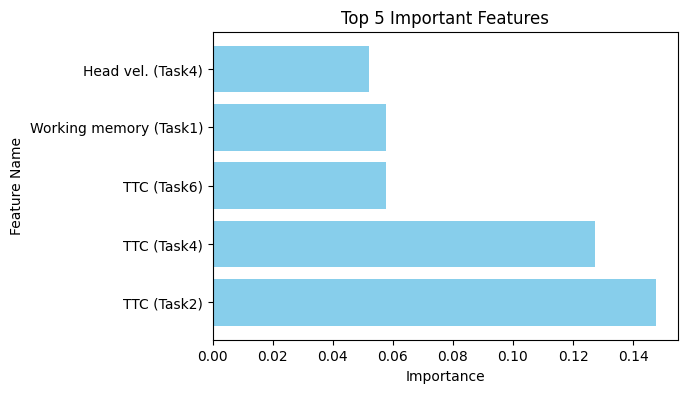

In [60]:
# Plot the MDI feature importance

feature_names = features.columns

feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Sort the features by importance in descending order
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# Select top 10 important features
top_features = feat_imp.head(5)

# Plot the top 10 important features
plt.figure(figsize=(6, 4))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature Name")
plt.title("Top 5 Important Features")
plt.show()

In [49]:
X = features[top_features["Feature"]]

### **3- Model**

#### **3-1- Random Forest Regressor**



In [50]:
forest = RandomForestRegressor()

# The hyperparameters grid
param_grid = {
    "n_estimators": [100, 150, 200, 250, 300],
    "max_depth": [5, 10, 15, 20, 25],
    "max_features": ["auto", "sqrt", "log2"]
}

# GridSearchCV object
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV object with the data
grid_search.fit(X, y)

# The best parameters
best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best hyperparameters:  {'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 200}


In [57]:
forest = RandomForestRegressor(n_estimators=200, max_depth=25, max_features="sqrt")

maes = []
rmses = []
r2s = []
corrs = []

kf = KFold(n_splits=5)
for train, test in kf.split(X):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    forest.fit(X_train, y_train)

    predictions = forest.predict(X_test)
    lower_limit = 0
    upper_limit = 48
    predictions = np.clip(predictions, lower_limit, upper_limit)

    mae = np.mean(np.absolute(predictions - y_test))
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    r2 = metrics.r2_score(y_test , predictions)
    corr_coef, p_value = pearsonr(predictions, y_test)

    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
    corrs.append(corr_coef)

mean_mae = sum(maes)/len(maes)
mean_rmse = sum(rmses)/len(rmses)
mean_r2 = sum(r2s)/len(r2s)
mean_corr = sum(corrs)/len(corrs)

In [58]:
report = {"MAE": [f"{round(mean_mae, 2)}({round(mean_mae/48, 2)}% of error)"],
          "RMSE": [f"{round(mean_rmse, 2)}({round(mean_rmse/48, 2)}% of error)"],
          "R^2": [f"{round(mean_r2, 3)*100}%"],
          "r": [f"{round(mean_corr, 3)*100}%"]
          }
pd.DataFrame(report, index=[" "])

,MAE,RMSE,R^2,r
,3.76(0.08% of error),4.67(0.1% of error),39.7%,66.9%


#### **3-2- XGB**

In [62]:
Prxgb = XGBRegressor()

# The hyperparameters to search
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

# Grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Tthe best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 150}


In [82]:
xgb = XGBRegressor(n_estimators=150, learning_rate=0.01, max_depth=4)

maes = []
rmses = []
r2s = []
corrs = []

kf = KFold(n_splits=5)
for train, test in kf.split(X):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    xgb.fit(X_train, y_train)

    predictions = forest.predict(X_test)
    lower_limit = 0
    upper_limit = 48

    mae = np.mean(np.absolute(predictions - y_test))
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    r2 = metrics.r2_score(y_test , predictions)
    corr_coef, p_value = pearsonr(predictions, y_test)

    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
    corrs.append(corr_coef)

mean_mae = sum(maes)/len(maes)
mean_rmse = sum(rmses)/len(rmses)
mean_r2 = sum(r2s)/len(r2s)
mean_corr = sum(corrs)/len(corrs)

In [83]:
report = {"MAE": [f"{round(mean_mae, 2)}({round(mean_mae/48, 2)}% of error)"],
          "RMSE": [f"{round(mean_rmse, 2)}({round(mean_rmse/48, 2)}% of error)"],
          "R^2": [f"{round(mean_r2*100, 3)}%"],
          "r": [f"{round(mean_corr*100, 2)}%"]
          }
pd.DataFrame(report, index=[" "])

,MAE,RMSE,R^2,r
,1.98(0.04% of error),2.44(0.05% of error),84.37%,94.36%
